# Homework Assignment 7

## Q1:

**Question 1:** Select two books and construct networks of people and locations, i.e. each link is between a a person and a location (20pt). Visualize the network using Cytoscape or Gephi (20pt).


### download books

In [ ]:
! mkdir -p  ./datasets/books
! wget -O ./datasets/books/mlk_book.pdf https://freekidsbooks.org/wp-content/uploads/2019/12/free-at-last-US_civil_rights-PD-FKB.pdf
! wget -O ./datasets/books/tied_up.txt https://www.gutenberg.org/ebooks/66832.txt.utf-8

--2021-11-29 07:12:43--  https://freekidsbooks.org/wp-content/uploads/2019/12/free-at-last-US_civil_rights-PD-FKB.pdf
Resolving freekidsbooks.org (freekidsbooks.org)... 63.250.45.193
Connecting to freekidsbooks.org (freekidsbooks.org)|63.250.45.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6889897 (6.6M) [application/pdf]
Saving to: ‘./datasets/books/mlk_book.pdf’

./datasets/books/ml 100%[===================>]   6.57M  4.02MB/s    in 1.6s    

2021-11-29 07:12:45 (4.02 MB/s) - ‘./datasets/books/mlk_book.pdf’ saved [6889897/6889897]

--2021-11-29 07:12:45--  https://www.gutenberg.org/ebooks/66832.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/cache/epub/66832/pg66832.txt [following]
--2021-11-29 07:12:46--  https://www.gutenbe

### Installs and imports:

In [ ]:
!pip install PyPDF2
!pip install turicreate
!pip install gensim
!pip install pyLDAvis
!pip install spaCy
!pip install afinn
!pip install nltk
!pip install plotly_express
!pip install networkx==2.5

     |████████████████████████████████| 1.6 MB 3.9 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


#### Downloads

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
!python -m spacy download en_core_web_lg 
# restarting runtime
import os
os.kill(os.getpid(), 9)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Fatal Python error: initsite: Failed to import the site module
Traceback (most recent call last):
  File "/usr/lib/python3.7/site.py", line 596, in <module>
    main()
  File "/usr/lib/python3.7/site.py", line 583, in main
    known_paths = addsitepackages(known_paths)
  File "/usr/lib/python3.7/site.py", line 366, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.7/site.py", line 213, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.7/site.py", line 174, in addpackage
    exec(line)
  File "<string>", line 1, in <module>
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/r

##### IMPORTS

In [ ]:
import PyPDF2
from typing import *
import numpy as np
import pandas as pd
from functools import lru_cache
import turicreate as turi 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import spacy
from tqdm import tqdm
import networkx as ntkx
import matplotlib.pyplot as plt

### read books and keep clean story text

#### read books raw text

In [ ]:
def read_book_pdf(book_path: str) -> str:
  book_text = ''
  with open(book_path, 'rb') as file:
    pdf_reader = PyPDF2.PdfFileReader(file)
    n_pages = pdf_reader.getNumPages()
    # iterating through pages and reading all raw text
    for i in range(n_pages):
      page_text = pdf_reader.getPage(i).extractText()
      if page_text!='' and page_text is not None:
        book_text+=f'{page_text}\n'
  return book_text

def read_books(book_paths: List[str]) -> List[str]:
  book_texts = []
  for book_path in book_paths:
    if book_path.endswith('.pdf'):
      book_texts.append(read_book_pdf(book_path))
    elif book_path.endswith('.txt'):
      book_text = ''
      with open(book_path) as f:
        book_text = f.read()
      book_texts.append(book_text)
    else:
      raise NotImplemented(f'dont know how to read {book_path.split(".")[-1]}')
  return book_texts


mlk_book_path = '/content/datasets/books/mlk_book.pdf'
tied_up_book_path = '/content/datasets/books/tied_up.txt'
books_texts = read_books([mlk_book_path, tied_up_book_path])

#### clean books test

In [ ]:
stop_words_set = set(stopwords.words("english"))
stemmer = PorterStemmer()

skip_word_func = lambda w: len(w)<2 or w.isdigit() or not w.isalpha() or stemmer.stem(w) in stop_words_set
def clean_text(text: str, stemming: bool = False) -> str:
  text = ' '.join([stemmer.stem(w) if stemming else w for w in word_tokenize(text) if not skip_word_func(w)])
  return text

clean_books_texts = [clean_text(x) for x in books_texts]
  

### extract NERS of people and locations and draw their graphs:

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
# I define that a person is linked to a location
#  only if the location appears (the token itself) up to N (def=10)  
#  tokens after a person and vice versa, if not, the location is discarded. 
all_entities_to_type_dict = {}
def extract_entities_and_locations_tuples(text: str, max_distance_between_person_and_location: int = 10) -> List[Tuple[str, str]]:
  global all_entities_to_type_dict
  people_to_loc_tuples = []
  doc = nlp(text)
  entities = doc.ents
  # keep only entities of people or locations
  entities_to_label_dict = {entity.text.lower():entity.label_ for entity in entities if entity.label_ in ['PERSON', 'LOC']}

  tokens = text.split()

  token_idx = 0
  while token_idx < len(tokens):
    token = tokens[token_idx]
    # if the token is an entity of type person
    if token.lower() in entities_to_label_dict:
      token_label = entities_to_label_dict[token.lower()]
      type_to_find = 'PERSON' if token_label == 'LOC' else 'LOC'
      temp_token_idx = token_idx + 1
      while temp_token_idx < len(tokens) and temp_token_idx-token_idx < max_distance_between_person_and_location:
        temp_token = tokens[temp_token_idx]
        if temp_token.lower() in entities_to_label_dict:
          temp_token_label = entities_to_label_dict[temp_token.lower()]
          # if we found a pair, add it to list of tuples (in the direction of the order 
          # the tokens were found) and progress the main index
          if temp_token_label == type_to_find:
            people_to_loc_tuples.append((token.lower(), temp_token.lower()))
            token_idx = temp_token_idx
            break
        temp_token_idx += 1
      token_idx = temp_token_idx
    else:
      token_idx += 1

  all_entities_to_type_dict.update(entities_to_label_dict)
  return people_to_loc_tuples

people_to_locs_lists_by_book_name = {book_name: extract_entities_and_locations_tuples(book) for book_name, book in zip(['MLK', 'TiedUp'], clean_books_texts)}

In [ ]:
! mkdir ./graphs

{'booker': 'PERSON', 'marcus garvey': 'PERSON', 'jim crow': 'PERSON', 'spotlight jackie robinson': 'PERSON', 'rosa parks': 'PERSON', 'lyndon baines': 'PERSON', 'ñmong': 'PERSON', 'atlantic': 'LOC', 'christopher columbusõs': 'PERSON', 'caribbean': 'LOC', 'western europeõs': 'LOC', 'atlantic ocean': 'LOC', 'africa': 'LOC', 'americas': 'LOC', 'europe': 'LOC', 'latin america': 'LOC', 'north america': 'LOC', 'orlando patterson': 'PERSON', 'eli whitney': 'PERSON', 'lower south': 'LOC', 'eugene genovese': 'PERSON', 'martin luther king': 'PERSON', 'di erent': 'PERSON', 'brethrenó': 'LOC', 'moses': 'PERSON', 'vann woodward': 'PERSON', 'þve': 'LOC', 'òmiddle passageó': 'LOC', 'þcant þgures': 'PERSON', 'barbara jordan john lewis': 'PERSON', 'jesse jackson': 'PERSON', 'mahalia jackson': 'PERSON', 'ßuence': 'PERSON', 'nelson mandela': 'PERSON', 'desmond tutu': 'PERSON', 'michael battle': 'PERSON', 'south': 'LOC', 'òking': 'PERSON', 'united statesõ declaration independence': 'PERSON', 'creator': 'PE

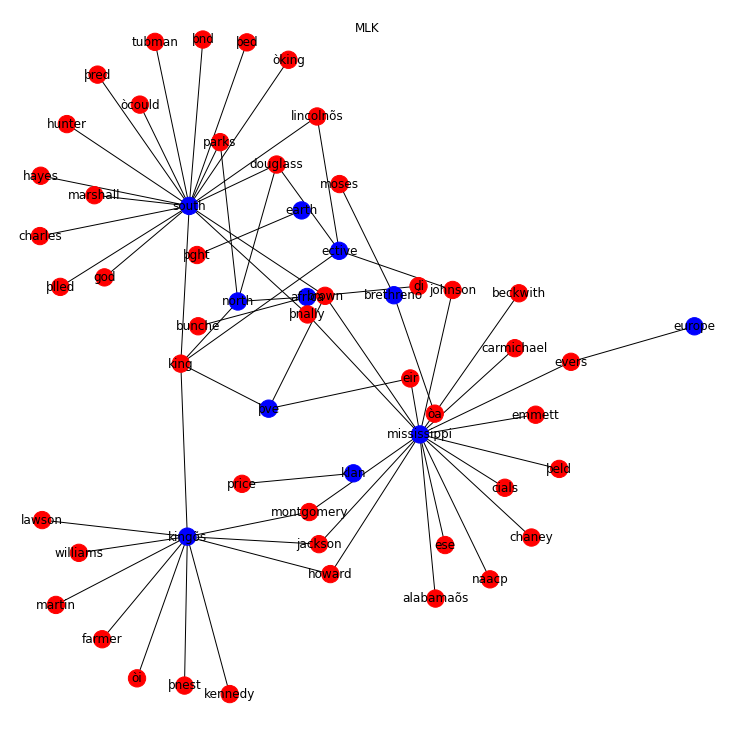

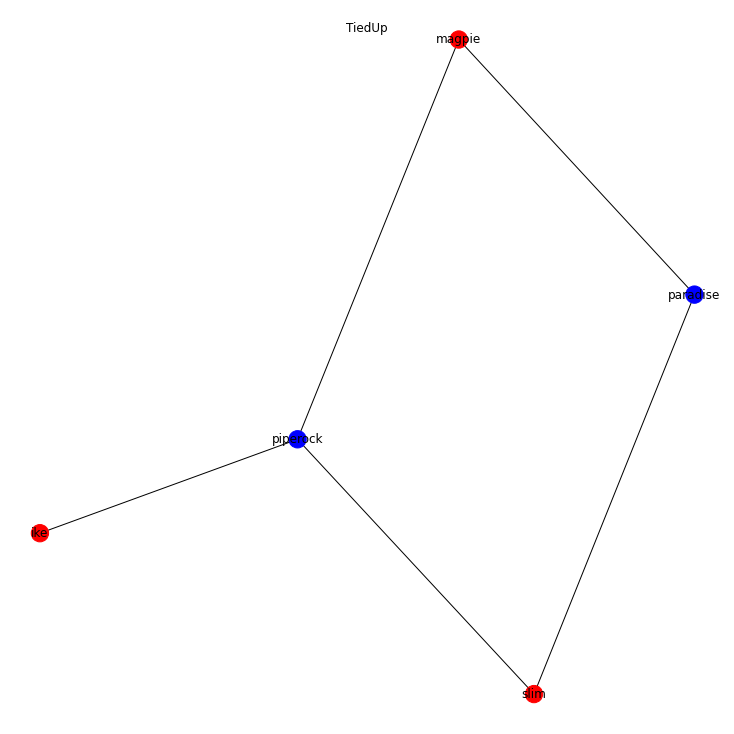

In [ ]:
def create_graph_from_edges_tuples(lst_of_edges: List[Tuple[str, str]], directed: bool = True, node_to_type_maps_dict: Dict[str, str] = None) -> Union[ntkx.DiGraph, ntkx.Graph]:
  """
  creates a un/directed graph (boolean argument directed, default=True) 
    from a list of tuples which represents the graph's edges.
  if a map of node type (PERSON/LOC) is provided, the type is added as an attribute.
  """
  print(node_to_type_maps_dict)
  g = ntkx.Graph() if not directed else ntkx.DiGraph()
  
  all_nodes = np.unique(np.stack(np.array(lst_of_edges)).flatten())
  g.add_edges_from(lst_of_edges)
  
  if node_to_type_maps_dict is not None:
    for node in all_nodes:
      g.nodes[node]['entity_type'] = node_to_type_maps_dict.get(node, 'UNK')

  return g
   


def create_graph_of_people_and_location_by_book(tuples_lst_by_book: Dict[str, List[Tuple[str, str]]], directed: bool = True, node_to_type_maps_dict: Dict[str, str] = None) -> None:
  """
  this function plots the graph using networkx.drawing.nx_pylab.draw_kamada_kawai method.
  this does not provide the answer for the question but is simply for debugging purposes.
  """
  graphs_by_book = {book_name: create_graph_from_edges_tuples(book_edges, directed, node_to_type_maps_dict) for book_name, book_edges in tuples_lst_by_book.items()}
  for book_name, book_graph in graphs_by_book.items():
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(book_name)
    if node_to_type_maps_dict is None:
      ntkx.drawing.nx_pylab.draw_kamada_kawai(book_graph, with_labels=True)
    else:
      c_map = []
      for _node in book_graph.nodes:
        type_of_node = book_graph.nodes[_node]['entity_type']
        if type_of_node == 'LOC':
          c_map.append('blue')
        elif type_of_node == 'PERSON':
          c_map.append('red')
        else:
          c_map.append('green')
      ntkx.drawing.nx_pylab.draw_kamada_kawai(book_graph, with_labels=True, node_color=c_map)
      ntkx.write_gml(book_graph, f"./graphs/{book_name}.gml")
      

# locations are blue and people are red. green should not appear as it is an indicator for a bug.
create_graph_of_people_and_location_by_book(people_to_locs_lists_by_book_name, directed=False, node_to_type_maps_dict=all_entities_to_type_dict)



#### The graphs generated in Cytoscape: (same color mapping)

MLK book:

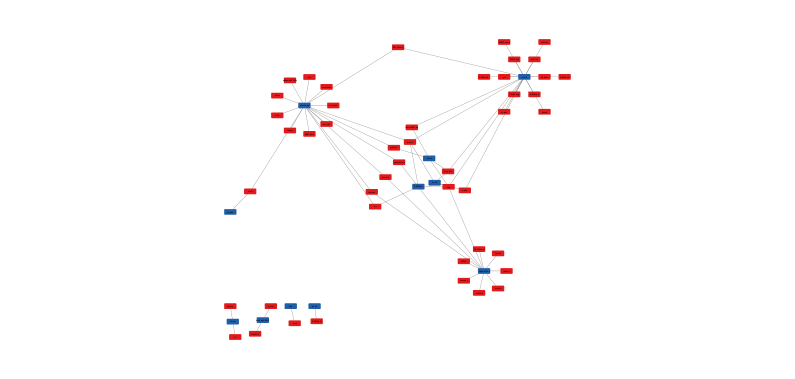

Tied up book:

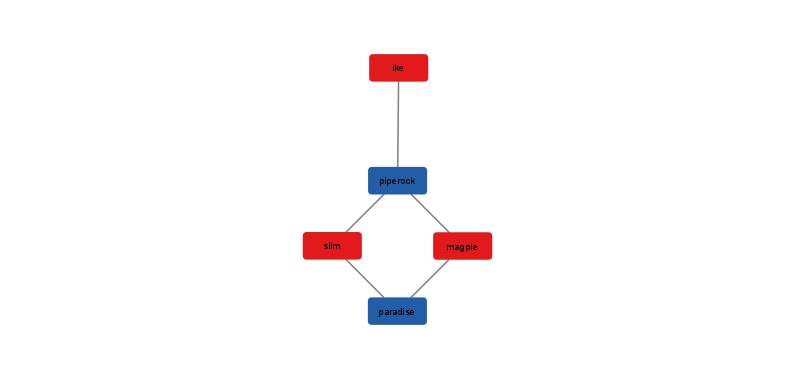




## Q2:

**Question 2:** Use the [Friends TV Show Transcript](https://www.kaggle.com/ryanstonebraker/friends-transcript)
to create and evaluate a classifier that given a line of text can predict
 who is the "friend" that said it (20pt). Using sentiment analysis identify who are the most and less friendly friends (20pt). Construct a classifier that can be given several text lines (quotes) from a specific episode that will predict the episode's season number (20pt).

### Preperations:

#### downloads and imports


##### downloads

In [ ]:
!mkdir ./datasets/friends_tv
!pip install kaggle 
!pip install turicreate
!pip install kaggle 
!pip install gensim
!pip install pyLDAvis
!pip install spaCy
!pip install afinn
!pip install nltk
!pip install plotly_express

mkdir: cannot create directory ‘./datasets/friends_tv’: No such file or directory
     |████████████████████████████████| 92.0 MB 18 kB/s 
     |████████████████████████████████| 86.4 MB 1.2 MB/s 
     |████████████████████████████████| 3.6 MB 39.3 MB/s 
     |████████████████████████████████| 3.5 MB 62.6 MB/s 
     |████████████████████████████████| 322 kB 68.8 MB/s 
     |████████████████████████████████| 18.3 MB 55.4 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 2.9 MB 42.7 MB/s 
     |████████████████████████████████| 3.8 MB 61.4 MB/s 
     |████████████████████████████████| 449 kB 45.6 MB/s 
     |████████████████████████████████| 20.1 MB 111.3 MB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13714 sha256=3c0b0a62738d9f191fd14a7aa9ee971f4d7f37968c6a70ddf621c6893c523665
  Stored in directory: /root/.cache/pip/wheels/b2/7f/f6/f180315b584f00445045ff1699b550fa895d09471337ce21c6
  Created whe

     |████████████████████████████████| 1.7 MB 15.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 43.1 MB/s 
     |████████████████████████████████| 15.7 MB 58.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=a29570392927002a9acbd847d3afe432c74477e0e476baa91588563472cee47b
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take i

     |████████████████████████████████| 52 kB 1.2 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=3a48af78cd56bf36fb0cfcb5610989e2b72e9dc54fdc0978eb22489e9e30e65e
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! cp "/content/gdrive/MyDrive/DataMining/APIs and Credentials/kaggle.json" "/content/kaggle.json"
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 

! kaggle datasets download ryanstonebraker/friends-transcript -p ./datasets/friends_tv
! unzip ./datasets/friends_tv/*.zip  -d ./datasets/friends_tv/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/1.72M [00:00<?, ?B/s]
100% 1.72M/1.72M [00:00<00:00, 56.4MB/s]
Archive:  ./datasets/friends_tv/friends-transcript.zip
  inflating: ./datasets/friends_tv/friends_quotes.csv  


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

!python -m spacy download en_core_web_lg
# restarting runtime
import os
os.kill(os.getpid(), 9)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=c5309d7f5bd4bbbd9b9c572117fe3263d40230f54c6aeee4a1dcc4081affebd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-0iz4tt0_/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


##### imports

In [ ]:
import os
from typing import *
import numpy as np
import pandas as pd
from functools import lru_cache
import turicreate as turi 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import spacy
from tqdm import tqdm
import networkx as ntkx
import matplotlib.pyplot as plt
from textblob import TextBlob
from afinn import Afinn
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import plotly.express as px

#### Part 1 - a classifier to predict speaker

In [177]:
path_to_friends_quotes = '/content/datasets/friends_tv/friends_quotes.csv'
quotes_csv = pd.read_csv(path_to_friends_quotes)


# preprocessing the dataframe - the dataset contains many authors that are not a part of the "close" friends (star characters of the show)
# in total, the dataset contains X unique authors, some of them are simply corrupted data (where the author name is "conteminated" with the actual quote).
# to enable more productive learning, i filter all the rows with authors that are not part of the subgroup: ['Rachel', 'Monica', 'Phoebe', 'Joey', 'Chandler', 'Ross'] (letter casing is ignored)
# moreover, some names appear in different notation, Ross Geller for example, might appear as "Dr. Ross"/"Dr. Ross Geller" etc., therefore
# i will convert all names to a standard naming convension as seen in the key_characters list
key_characters = np.array(['rachel', 'monica', 'phoebe', 'joey', 'chandler', 'ross'])
print(f'Before removing all quotes that are not said by a key character, the dataset has :{len(quotes_csv)} rows.')

def convert_to_familiar_naming_convesion(names):
  converted_names = []
  for name in names:
    for n in key_characters:
      if n in name.lower():
        converted_names.append(n)
      else:
        converted_names.append(name.lower())
  return np.array(converted_names)

quotes_csv[['author']] = quotes_csv[['author']].apply(convert_to_familiar_naming_convesion)
quotes_csv = quotes_csv[quotes_csv['author'].isin(key_characters)]

print(f'After removing all quotes that are not said by a key character, the dataset has :{len(quotes_csv)} rows.')

Before removing all quotes that are not said by a key character, the dataset has :60291 rows.
After removing all quotes that are not said by a key character, the dataset has :45451 rows.


In [178]:
# creating a word2vec model based on the words in the quotes.
import re
import gensim

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
re_words_split = re.compile("(\w+)")

def txt2words(s):
    s = re.sub("[^a-zA-Z]", " ", s).lower()
    return re_words_split.findall(s)

class Sentences(object):
        def __init__(self, txt):
            self._txt = txt
            
        def __iter__(self):
            for s in tokenizer.tokenize(self._txt):                                    
                yield txt2words(s)

# We will create a Word2Vec model based on Dickens work
txt = ' '.join(quotes_csv['quote'].values)
sentences = Sentences(txt)
model = gensim.models.Word2Vec(sentences, size=50, window=5, min_count=1, workers=6)

In [179]:
df_with_features = quotes_csv[['quote','author']].copy()
df_with_features['clean_tokens'] = df_with_features['quote'].apply(lambda x: txt2words(x))
df_with_features['is_question'] = df_with_features['quote'].apply(lambda x: x.count('?'))
df_with_features['is_shout'] = df_with_features['quote'].apply(lambda x: x.count('1'))
df_with_features['n_tokens'] = df_with_features['clean_tokens'].apply(lambda x: len(x))

embeddings = [np.array([model[w] for w in row]) for row in df_with_features['clean_tokens']]
mean_embeddings = [x.mean(axis=0) if len(x.shape)>1 else x for x in embeddings]

df_with_features['mean_embedding'] = mean_embeddings # .apply(lambda x: np.array([model[w] for w in x if w in model.wv.vocab]).mean())
print(f'dataset size before removing quotes with no text: {len(df_with_features)}')
df_with_features = df_with_features[[x.shape[0]==50 for x in df_with_features['mean_embedding']]]
print(f'dataset size after removing quotes with no text: {len(df_with_features)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



dataset size before removing quotes with no text: 45451
dataset size after removing quotes with no text: 45440


In [180]:
quouts_sframe = turi.SFrame(df_with_features)
quouts_sframe['quote_TF-IDF'] = turi.text_analytics.tf_idf(quouts_sframe['quote'])

train, test = quouts_sframe.random_split(0.8)

features_list = ['is_question', 'is_shout', 'n_tokens', 'mean_embedding', 'quote_TF-IDF']
cls = turi.classifier.create(train,features=features_list, target="author", verbose=True) # to enable/disable report.


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 34498

Number of classes           : 6

Number of feature columns   : 5

Number of unpacked features : 32174

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.809685     | 0.223201          | 0.199339            | 1.781749          | 1.788085            |

| 2         | 1.615814     | 0.230158          | 0.203744            | 1.774355          | 1.785703            |

| 3         | 2.679960     | 0.237637          | 0.202093            | 1.767874          | 1.783983            |

| 4         | 3.615223     | 0.244652          | 0.202093            | 1.761605          | 1.783195            |

| 5         | 4.526416     | 0.251087          | 0.202643            | 1.757141          | 1.782659            |

| 10        | 9.085803     | 0.279784          | 0.209251            | 1.734298          | 1.780392            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 34498

Number of classes           : 6

Number of feature columns   : 5

Number of unpacked features : 32174

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.831534     | 0.221085          | 0.202093            | 1.767870          | 1.788855            |

| 2         | 1.702292     | 0.231086          | 0.199890            | 1.765659          | 1.786928            |

| 3         | 2.662902     | 0.234709          | 0.203194            | 1.765146          | 1.785208            |

| 4         | 3.556994     | 0.238999          | 0.200991            | 1.764734          | 1.784612            |

| 5         | 4.359344     | 0.243927          | 0.203194            | 1.764128          | 1.784463            |

| 10        | 7.803647     | 0.244478          | 0.197687            | 1.763640          | 1.784358            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 34498

Number of classes           : 6

Number of feature columns   : 5

Number of unpacked features : 32174

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.840375     | 0.223201          | 0.199339            | 1.765583          | 1.785612            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 34498

Number of classes           : 6

Number of feature columns   : 5

Number of unpacked features : 32174

Number of coefficients      : 160875

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.330321     | 0.360485          | 0.204295            |

| 1         | 4        | 1.000000  | 3.954410     | 0.559308          | 0.213656            |

| 2         | 5        | 1.000000  | 7.407693     | 0.608615          | 0.193833            |

| 3         | 6        | 1.000000  | 10.913519    | 0.653893          | 0.198238            |

| 4         | 7        | 1.000000  | 14.462892    | 0.670126          | 0.189427            |

| 6         | 10       | 1.000000  | 21.672502    | 0.706215          | 0.194934            |

| 7         | 11       | 1.000000  | 25.170870    | 0.718882          | 0.191630            |

| 8         | 12       | 1.000000  | 28.662924    | 0.727752          | 0.191630            |

| 9         | 13       | 1.000000  | 32.196298    | 0.744420          | 0.192181            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.2092511013215859
PROGRESS: RandomForestClassifier          : 0.19768722466960353
PROGRESS: DecisionTreeClassifier          : 0.19933920704845814
PROGRESS: LogisticClassifier              : 0.1921806167400881
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [181]:
def predict_speaker_of_text(raw_text: str, model=model,cls = cls):
  df_with_features = pd.DataFrame()
  df_with_features['clean_tokens'] = [txt2words(raw_text) ]
  df_with_features['is_question'] = raw_text.count('?')
  df_with_features['is_shout'] = raw_text.count('!')
  df_with_features['n_tokens'] = len(txt2words(raw_text))
  print(df_with_features)
  embeddings = np.array([model[w] for w in txt2words(raw_text) if w in model.wv.vocab]).mean(axis=0)
  mean_embeddings = [x.mean(axis=0) if len(x.shape)>1 else x for x in embeddings]
  df_with_features['mean_embedding'] = [mean_embeddings]
  prediction_sframe = turi.SFrame(df_with_features)
  prediction_sframe['quote_TF-IDF'] = turi.text_analytics.tf_idf(turi.SArray([raw_text]))
  return cls.predict(prediction_sframe)[0]

a_random_sentence = 'Drama is all i need'

print(f'the model predicted that the sentence:\n"{a_random_sentence}"\nwas said by:{predict_speaker_of_text(a_random_sentence)}')

a_random_sentence = 'some of us have work to do'
print(f'the model predicted that the sentence:\n"{a_random_sentence}"\nwas said by:{predict_speaker_of_text(a_random_sentence)}')

                clean_tokens  is_question  is_shout  n_tokens
0  [drama, is, all, i, need]            0         0         5
the model predicted that the sentence:
"Drama is all i need"
was said by:ross
                         clean_tokens  is_question  is_shout  n_tokens
0  [some, of, us, have, work, to, do]            0         0         7
the model predicted that the sentence:
"some of us have work to do"
was said by:monica


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



### Part 2 - Friendliest friends

In [ ]:
!pip install textblob

In [182]:
path_to_friends_quotes = '/content/datasets/friends_tv/friends_quotes.csv'
quotes_csv = pd.read_csv(path_to_friends_quotes)

# preprocessing the dataframe - the dataset contains many authors that are not a part of the "close" friends (star characters of the show)
# in total, the dataset contains X unique authors, some of them are simply corrupted data (where the author name is "conteminated" with the actual quote).
# to enable more productive learning, i filter all the rows with authors that are not part of the subgroup: ['Rachel', 'Monica', 'Phoebe', 'Joey', 'Chandler', 'Ross'] (letter casing is ignored)
# moreover, some names appear in different notation, Ross Geller for example, might appear as "Dr. Ross"/"Dr. Ross Geller" etc., therefore
# i will convert all names to a standard naming convension as seen in the key_characters list
key_characters = np.array(['rachel', 'monica', 'phoebe', 'joey', 'chandler', 'ross'])
print(f'Before removing all quotes that are not said by a key character, the dataset has :{len(quotes_csv)} rows.')

def convert_to_familiar_naming_convesion(names):
  converted_names = []
  for name in names:
    for n in key_characters:
      if n in name.lower():
        converted_names.append(n)
      else:
        converted_names.append(name.lower())
  return np.array(converted_names)

quotes_csv[['author']] = quotes_csv[['author']].apply(convert_to_familiar_naming_convesion)
quotes_csv = quotes_csv[quotes_csv['author'].isin(key_characters)]

print(f'After removing all quotes that are not said by a key character, the dataset has :{len(quotes_csv)} rows.')


Before removing all quotes that are not said by a key character, the dataset has :60291 rows.
After removing all quotes that are not said by a key character, the dataset has :45451 rows.


In [183]:
# for each quote, the polarity and subjectivity from textblob and score from affin will be calculated
# for each friend, we will calculate a mean score of all the quotes he said.
# we will show which friend was the least friendly ever (a single worst quote) and the most friednly.
# and which of the friends is the friendliest and least friendly on average (the mean score) 
quotes_textblob_and_afinn_features_df = pd.DataFrame()
features_list = [
                 'TextBlob text polarity', 
                 'TextBlob text subjectivity', 
                 'Afinn text score',
                 ]
# TextBlob features
textblob_text_polarity = quotes_csv['quote'].apply(lambda quote: TextBlob(quote).sentiment.polarity)
quotes_textblob_and_afinn_features_df['TextBlob text polarity'] = textblob_text_polarity

textblob_text_subjectivity = quotes_csv['quote'].apply(lambda quote: TextBlob(quote).sentiment.subjectivity)
quotes_textblob_and_afinn_features_df['TextBlob text subjectivity'] = textblob_text_subjectivity
# Afinn features
afinn = Afinn()
afinn_text_score = quotes_csv['quote'].apply(lambda t: afinn.score(t))
quotes_textblob_and_afinn_features_df['Afinn text score'] = afinn_text_score
# original data
quotes_textblob_and_afinn_features_df['org_quote'] = quotes_csv['quote']
quotes_textblob_and_afinn_features_df['author'] = quotes_csv['author']

quotes_textblob_and_afinn_features_sframe = turi.SFrame(quotes_textblob_and_afinn_features_df)

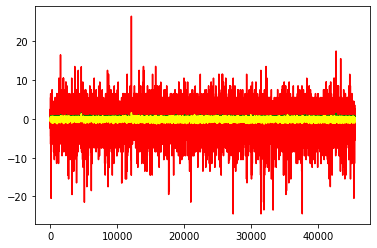

In [184]:
# to examine how all quotes differ, we will perform a PCA on the scores, coloring the PCs' datapoints by author
pca = PCA(n_components=3)
pca_comp = pca.fit_transform(quotes_textblob_and_afinn_features_sframe[['TextBlob text polarity', 'TextBlob text subjectivity', 'Afinn text score']].to_numpy())
pc_df = pd.DataFrame(data = pca_comp, columns = ['PC1', 'PC2', 'PC3'])

pc_with_author_df = pd.concat([pc_df, quotes_textblob_and_afinn_features_sframe[['author']].to_dataframe()], axis = 1)
# px.scatter_3d(pc_with_author_df, x="PC1", y="PC2",z="PC3", color="author")
fig, ax = plt.subplots()
x_axis = np.arange(0, len(pc_df), 1)
ax.plot(x_axis, pc_df[['PC1']].values, color='red')
ax.plot(x_axis, pc_df[['PC2']].values, color='green')
ax.plot(x_axis, pc_df[['PC3']].values, color='yellow')
plt.show()

According to the PC analysis, PC #1 is responsible for the majority of variance in the extracted features values. 
Therefore, by checking the correlation of PC1 with all original features, the most correlated feature with PC1 will represent the level of friendliesness of the quote. By averaging all scores of the most correlated feature (by author), we can infer which author is the frienliest friend.

[0 1 2]
[-0.45516310488785805, -0.18804413409521656, -0.9999691138874773]


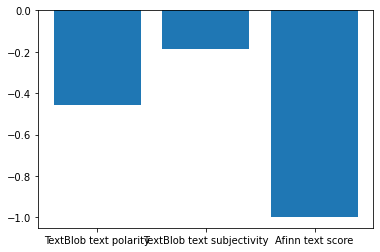

In [185]:
from scipy.stats import pearsonr as pr
def correlate_pc1_with_all_features(pc_values=pc_df[['PC1']], 
                                    data_sf=quotes_textblob_and_afinn_features_sframe,
                                    features_to_correlate=['TextBlob text polarity', 'TextBlob text subjectivity', 'Afinn text score']):
  features_scores_df = pd.DataFrame(columns=[f'feature_name', 'correlation_with_pc'])
  features_scores = []
  for f_idx, f_name in enumerate(features_to_correlate):
    features_scores.append(pr(data_sf[[f_name]].to_numpy().flatten(), pc_values.values.flatten())[0])
  
  features_scores_df[f'feature_name'] = features_to_correlate
  features_scores_df[f'correlation_with_pc'] = features_scores
  fig, ax = plt.subplots()
  print(np.arange(0, len(features_to_correlate), 1))
  print(features_scores)

  ax.bar(np.arange(0, len(features_to_correlate), 1), features_scores)
  ax.set_xticks(np.arange(0, len(features_to_correlate), 1))
  ax.set_xticklabels(features_to_correlate)
  # fig = px.bar(features_scores_df, x='feature_name', y='correlation_with_pc')
  # fig.show()
  plt.show()

correlate_pc1_with_all_features()

The feature "Afinn text score" is the most (negatively) correlated with PC1, therefore, we will average the feature's scores by author name and rank all authors by the mean score.

In [186]:
import turicreate.aggregate as agg

chosen_feature_name = 'Afinn text score'
authors_friendlieness_scores = quotes_textblob_and_afinn_features_sframe.groupby('author', operations={f'mean_{chosen_feature_name}': agg.MEAN(chosen_feature_name)})
sorted_authors_friendlieness_scores = authors_friendlieness_scores.sort(f'mean_{chosen_feature_name}', ascending=False)

fig = px.bar(sorted_authors_friendlieness_scores, x='author', y=f'mean_{chosen_feature_name}')
fig.show()

As we can see, Chandler is the most unfriendly friend, while Monica is the friendliest one.

### Part 3 - Season of quotes text classifier

In [187]:
quotes_sframe_org = turi.SFrame.read_csv('/content/datasets/friends_tv/friends_quotes.csv')

Finished parsing file /content/datasets/friends_tv/friends_quotes.csv

Parsing completed. Parsed 100 lines in 0.159863 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float,str,str,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/friends_tv/friends_quotes.csv

Parsing completed. Parsed 60291 lines in 0.156272 secs.

In [188]:
# aggregate the original sframe by the season:
import itertools

quotes_sframe = quotes_sframe_org.groupby(['episode_number', 'season'], {"quotes":agg.CONCAT("quote")})
# quotes_sframe[0]['quotes'][0]
quotes_sframe['quotes'] = quotes_sframe['quotes'].apply(lambda x: [token for token in x ])


We were instructed to provide a prediction for the season number given "several text lines (quotes) from a specific episode". 
Due to the unknown number of quotes provided for prediction, i will create a mean score for each episode, derived from multiple quotes. 
all episodes of a given season will be considered as a single cluster, and i will calculate for each season its cluster's centroid. 
To predict the season of a collection of any new quotes, i will calculate the mean scores of the new quotes, and the cluster centroid which is the closest to the new quotes scores will be considered as the predicted cluster and hence the predicted season.

In [189]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [202]:
quotes_df_with_features = quotes_sframe.copy().to_dataframe()  
def calc_features_for_single_episode_quotes(single_episode_quotes):
  quotes_len = []
  quotes_embdedings = []
  fraction_of_stop_words = []
  for single_quote in single_episode_quotes:
    tokens = txt2words(single_quote)
    stop_words = list(filter(lambda x: x in turi.text_analytics.stop_words(lang='en'), tokens))
    quotes_len.append(len(tokens))
    fraction_of_stop_words.append(len(stop_words)/len(tokens) if len(tokens)!=0 else 0)
    
    embeddings = np.array([model[w] for w in tokens if w in model.wv.vocab])
    mean_embeddings = embeddings.mean(axis=0) if len(embeddings.shape)>1 else embeddings 
    # print(np.array(mean_embeddings).shape)
    if len(mean_embeddings) != 0:
      quotes_embdedings.append(mean_embeddings)
      
  mean_quotes_len = np.array(quotes_len).mean()
  mean_fraction_of_stop_words = np.array(fraction_of_stop_words).mean()
  mean_quotes_embdedings = np.array(quotes_embdedings).mean(axis=0)
  return mean_quotes_len, mean_fraction_of_stop_words, mean_quotes_embdedings

quotes_df_with_features[['mean_quotes_len', 'mean_fraction_of_stop_words']] = None
mean_quotes_embdedings = []
for row_idx, row in quotes_df_with_features.iterrows():
  row_feats = calc_features_for_single_episode_quotes(row['quotes'])
  quotes_df_with_features.loc[row_idx, 'mean_quotes_len'] = row_feats[0]
  quotes_df_with_features.loc[row_idx, 'mean_fraction_of_stop_words'] = row_feats[1]
  mean_quotes_embdedings.append(row_feats[2])
  # quotes_df_with_features.loc[row_idx, 'mean_quotes_embdedings'] = [row_feats[2]]
mean_quotes_embdedings = np.array(mean_quotes_embdedings)
for i in range(len(mean_quotes_embdedings[0])):
  quotes_df_with_features[f'mean_quotes_embdedings_{i}'] = mean_quotes_embdedings[:, i]
quotes_df_with_features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



,episode_number,season,quotes,mean_quotes_len,mean_fraction_of_stop_words,mean_quotes_embdedings_0,mean_quotes_embdedings_1,mean_quotes_embdedings_2,mean_quotes_embdedings_3,mean_quotes_embdedings_4,mean_quotes_embdedings_5,mean_quotes_embdedings_6,mean_quotes_embdedings_7,mean_quotes_embdedings_8,mean_quotes_embdedings_9,mean_quotes_embdedings_10,mean_quotes_embdedings_11,mean_quotes_embdedings_12,mean_quotes_embdedings_13,mean_quotes_embdedings_14,mean_quotes_embdedings_15,mean_quotes_embdedings_16,mean_quotes_embdedings_17,mean_quotes_embdedings_18,mean_quotes_embdedings_19,mean_quotes_embdedings_20,mean_quotes_embdedings_21,mean_quotes_embdedings_22,mean_quotes_embdedings_23,mean_quotes_embdedings_24,mean_quotes_embdedings_25,mean_quotes_embdedings_26,mean_quotes_embdedings_27,mean_quotes_embdedings_28,mean_quotes_embdedings_29,mean_quotes_embdedings_30,mean_quotes_embdedings_31,mean_quotes_embdedings_32,mean_quotes_embdedings_33,mean_quotes_embdedings_34,mean_quotes_embdedings_35,mean_quotes_embdedings_36,mean_quotes_embdedings_37,mean_quotes_embdedings_38,mean_quotes_embdedings_39,mean_quotes_embdedings_40,mean_quotes_embdedings_41,mean_quotes_embdedings_42,mean_quotes_embdedings_43,mean_quotes_embdedings_44,mean_quotes_embdedings_45,mean_quotes_embdedings_46,mean_quotes_embdedings_47,mean_quotes_embdedings_48,mean_quotes_embdedings_49
0,18.0,9.0,"[(into receiver)Hello? Hey Charlie, what do yo...",12.833333,0.656649,0.279602,0.729692,0.074632,-1.201502,-0.791971,-0.310972,-0.642774,-0.873141,-0.383274,0.104119,0.216720,0.094234,1.124417,-0.469194,-0.425328,0.373611,0.685978,0.215865,0.064873,-0.284628,-0.586580,0.502536,-0.882126,-0.299545,0.018433,-0.489086,0.275092,0.063654,0.274143,-0.453943,-0.131990,0.246916,-0.185259,-0.589768,-0.889817,0.007126,-0.612161,-0.379424,0.206691,-0.379297,0.066842,-0.306711,-0.896813,0.362629,-0.761797,-0.060008,0.476640,0.343773,0.010957,-0.154127
1,3.0,3.0,"[Chandler and Joey's, Chandler is sitting read...",13.106838,0.61423,0.144159,0.721846,-0.037474,-1.222369,-0.693599,-0.407440,-0.634820,-0.842211,-0.247254,0.117805,0.288236,0.059766,1.183982,-0.408938,-0.258428,0.247064,0.778842,0.220879,0.083567,-0.140260,-0.619765,0.306294,-0.753933,-0.274218,0.033596,-0.458956,0.237654,0.026361,0.245916,-0.408585,-0.094237,0.327311,-0.245820,-0.604169,-0.927244,-0.038162,-0.561087,-0.261236,0.043413,-0.311637,0.052075,-0.192849,-0.813603,0.386395,-0.776796,-0.093594,0.418509,0.287702,0.003282,-0.065001
2,12.0,6.0,"[What?, Im sorry, I was just reading the joke...",13.012,0.662865,0.251727,0.758589,0.025503,-1.285598,-0.791992,-0.371451,-0.693738,-0.939099,-0.391440,0.117118,0.255339,0.053823,1.240712,-0.487507,-0.425894,0.365967,0.740532,0.199068,0.073457,-0.196226,-0.630805,0.420915,-0.919340,-0.351260,0.043754,-0.458257,0.206029,0.131820,0.200408,-0.440502,-0.118459,0.377637,-0.228091,-0.670164,-0.978308,-0.019900,-0.611137,-0.322677,0.121041,-0.369916,0.049305,-0.301211,-0.907590,0.368642,-0.837163,-0.051636,0.437294,0.294497,0.058974,-0.164882
3,1.0,3.0,"[I want you to say that you like her!, I can't...",12.016598,0.665949,0.267584,0.787345,0.019118,-1.290135,-0.765642,-0.347854,-0.699476,-0.930123,-0.397911,0.113599,0.310202,0.085052,1.274412,-0.473143,-0.354918,0.330478,0.755610,0.130996,0.061428,-0.188086,-0.614718,0.460632,-0.853852,-0.317604,0.033533,-0.414833,0.190941,0.130707,0.214045,-0.404837,-0.102184,0.383133,-0.185580,-0.698161,-0.926275,-0.006879,-0.596260,-0.306142,0.099889,-0.418920,-0.003835,-0.300750,-0.854250,0.417990,-0.862165,-0.003408,0.474122,0.268446,0.014795,-0.151262
4,10.0,6.0,"[Let me ask you, why is everybody using these ...",12.643478,0.675428,0.279264,0.825097,0.020456,-1.303907,-0.780243,-0.351313,-0.706047,-0.946105,-0.371618,0.071771,0.242584,0.107406,1.198737,-0.451243,-0.379167,0.359405,0.807696,0.121582,0.181305,-0.208682,-0.631937,0.460464,-0.908824,-0.378974,0.027847,-0.518297,0.256950,0.064258,0.278992,-0.434325,-0.120739,0.321727,-0.213695,-0.657877,

In [256]:
# cluster centroids will be calculated using the mean euclidean distance of all scores in a season 

from sklearn.neighbors import NearestCentroid


seasons_numbers = quotes_df_with_features['season'].unique()
seasons_centroids_by_season = {}

X = []
y = []
for season_n in seasons_numbers:
  all_data_in_season = quotes_df_with_features[quotes_df_with_features['season']==season_n]
  all_scores_in_season = all_data_in_season[['mean_quotes_len', 'mean_fraction_of_stop_words'] + [f'mean_quotes_embdedings_{i}' for i in range(len(mean_quotes_embdedings[0]))]]
  # print(all_scores_in_season)
  # break
  X += [line for line in all_scores_in_season.values]
  y += [season_n for i in range(len(all_scores_in_season.values))]

clf = NearestCentroid()
clf.fit(X, y)
# collect the centroids by season:
y_idx = 0
seasons_centroids_by_season = {}
for y_s in y:
  if y_s not in seasons_centroids_by_season:
    seasons_centroids_by_season[y_s] = clf.centroids_[y_idx]
    y_idx += 1   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:968: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



In [263]:
def predict_season_by_episode_quotes(lst_of_quotes_from_episode: List[str], centroid_finder=clf):
  # calculate all the features for the episode's quotes.
  mean_quotes_len, mean_fraction_of_stop_words, mean_quotes_embdedings = calc_features_for_single_episode_quotes(lst_of_quotes_from_episode)
  single_episode_quotes_df = pd.DataFrame()
  single_episode_quotes_df[['mean_quotes_len', 'mean_fraction_of_stop_words']] = None
  single_episode_quotes_df.loc[0, 'mean_quotes_len'] = mean_quotes_len
  single_episode_quotes_df.loc[0, 'mean_fraction_of_stop_words'] = mean_fraction_of_stop_words
  for i in range(len(mean_quotes_embdedings)):
    single_episode_quotes_df.loc[0, f'mean_quotes_embdedings_{i}'] = mean_quotes_embdedings[i]
  
  # find which centroid is the closest!
  predicted_season = centroid_finder.predict(single_episode_quotes_df.values)

  return predicted_season

# sample quotes taken from season 6
predicted_season_number = predict_season_by_episode_quotes(["Well! What happened?! Did we miss it?",
                                  "Ross and Rachel left us a message saying they were getting married! isn't that why you guys are here?"])[0]

print(f'{"#"*20}\nFor two quotes taken from season 6, my custom classifier predicted that the season is {int(predicted_season_number)}\n{"#"*20}')                                  

####################
For two quotes taken from season 6, my custom classifier predicted that the season is 6
####################


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

